In [104]:
# 1. IMPORTS
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [105]:
# 2. CARGAR DATOS
housing = fetch_california_housing()
housing_df = pd.DataFrame(housing["data"], columns=housing["feature_names"])
housing_df["target"] = housing["target"]  

print(f"\nDataset: {housing_df.shape}")

print("\nVARIABLES:")

for i in housing_df.columns:
    print(f"   {i}")



print("ESTADÍSTICAS DEL SATASET:")

print(housing_df.describe())



Dataset: (20640, 9)

VARIABLES:
   MedInc
   HouseAge
   AveRooms
   AveBedrms
   Population
   AveOccup
   Latitude
   Longitude
   target
ESTADÍSTICAS DEL SATASET:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        target  
count  20640.000000  20640.000000  20640.000000  20640.00

In [106]:
# 3. pROCESAR DATOS
# arriba aparece que es de dimension n*9, uno de esos elementos es el objetivo
# Separacion entre variables de x y objetivo (y)
X = housing_df.drop('target', axis=1)
y = housing_df['target']

# Conjunto de entrenamiento y prueba (entranamiento es mayor)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nSubset para entrenamiento: {X_train.shape[0]}")
print(f"Subset para prueba: {X_test.shape[0]}")

# Normalizar las características (importante para Ridge)
# las varaibles deben estar en igual escala para comparar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Subset para entrenamiento: 16512
Subset para prueba: 4128


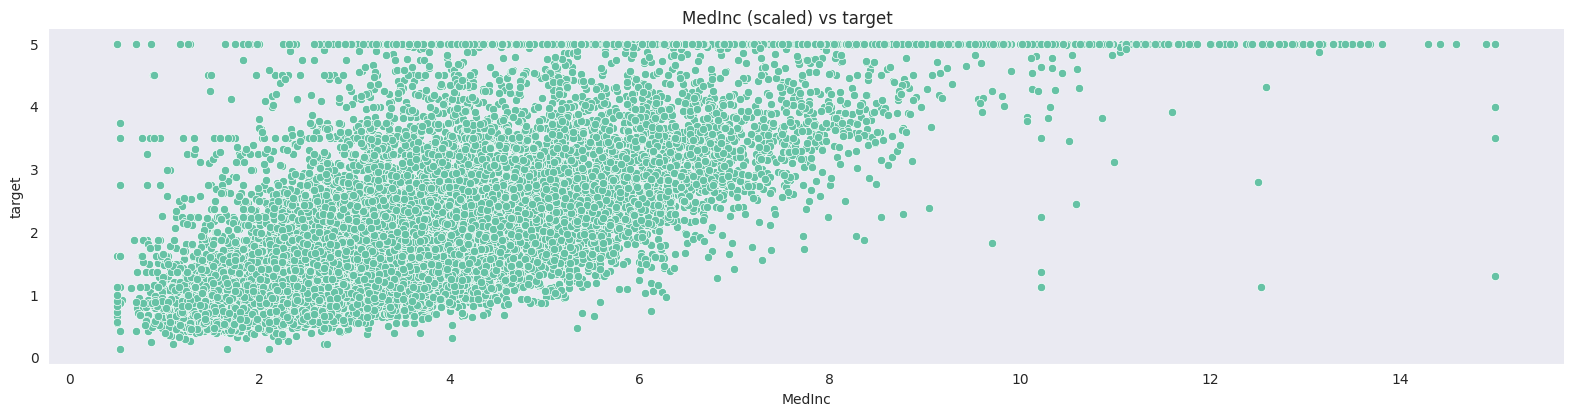

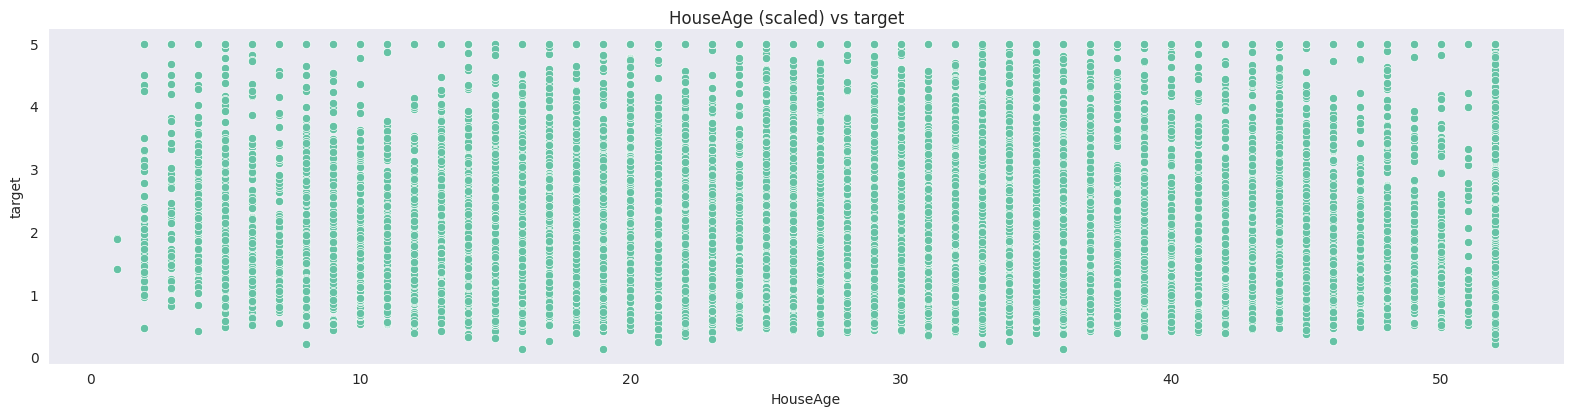

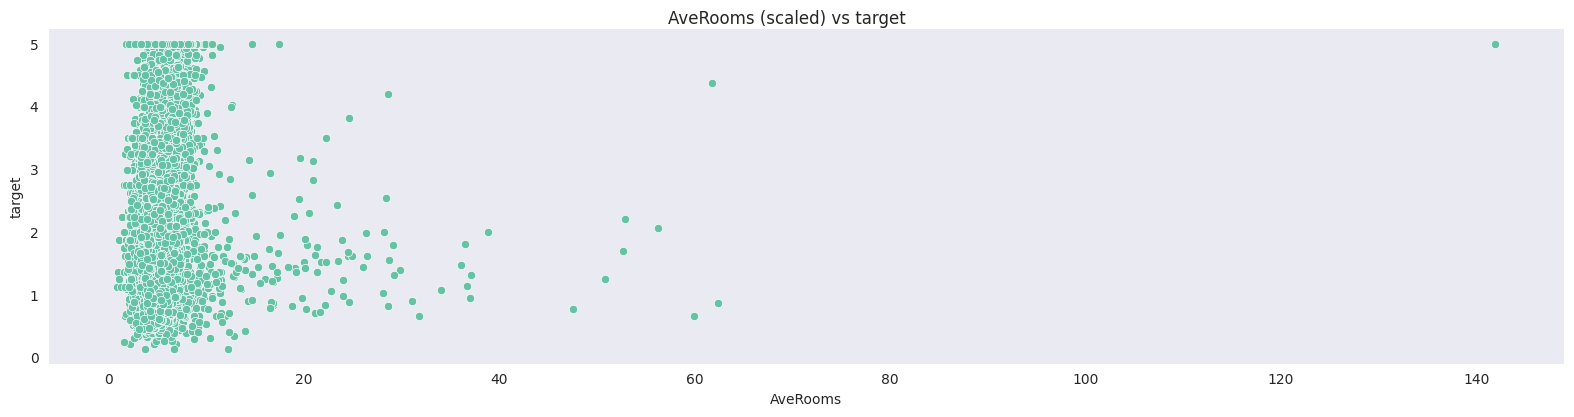

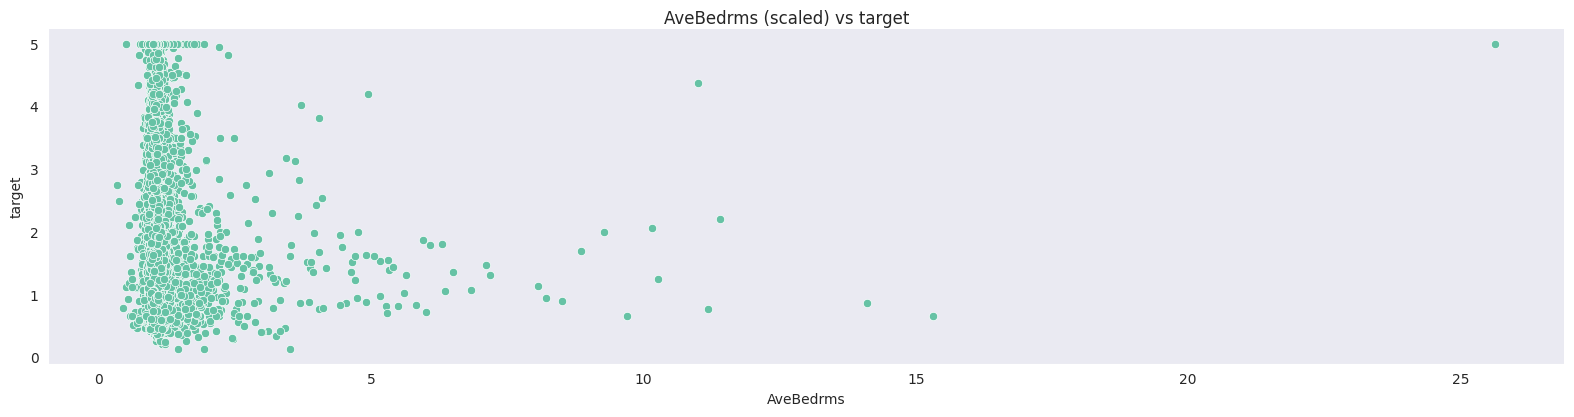

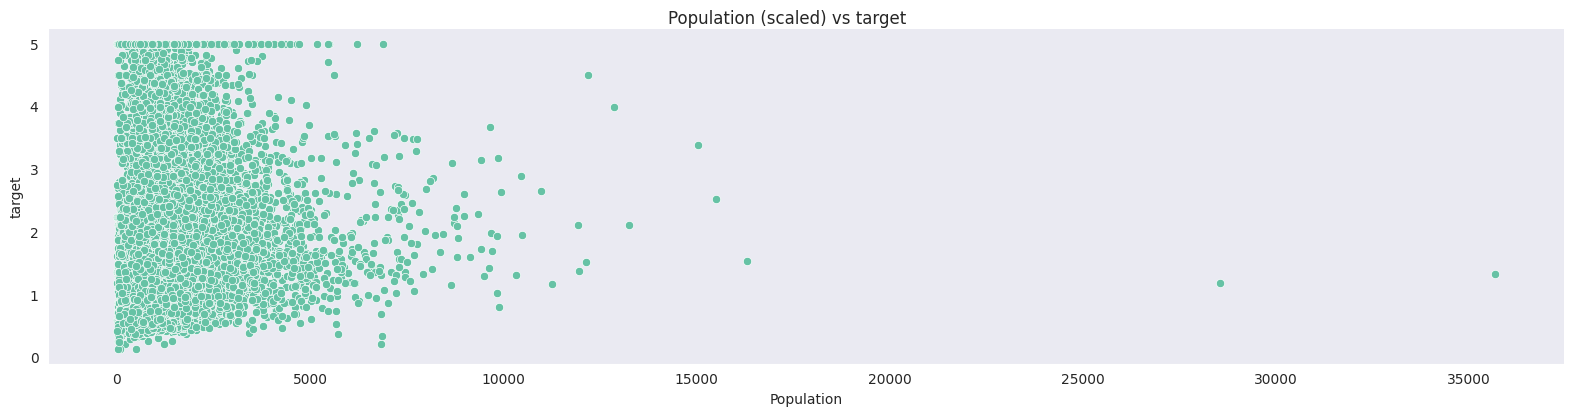

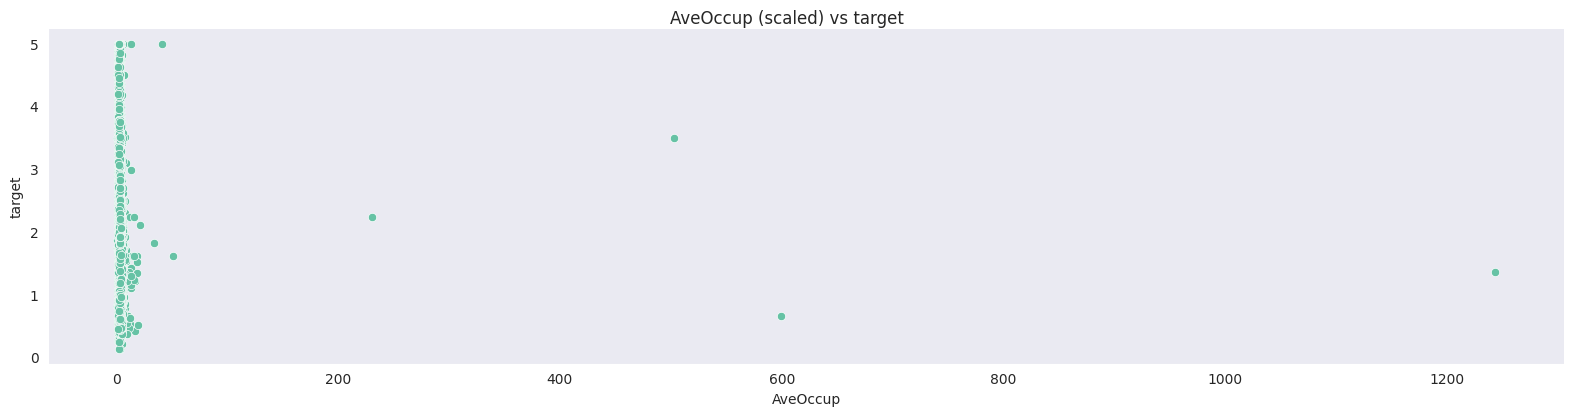

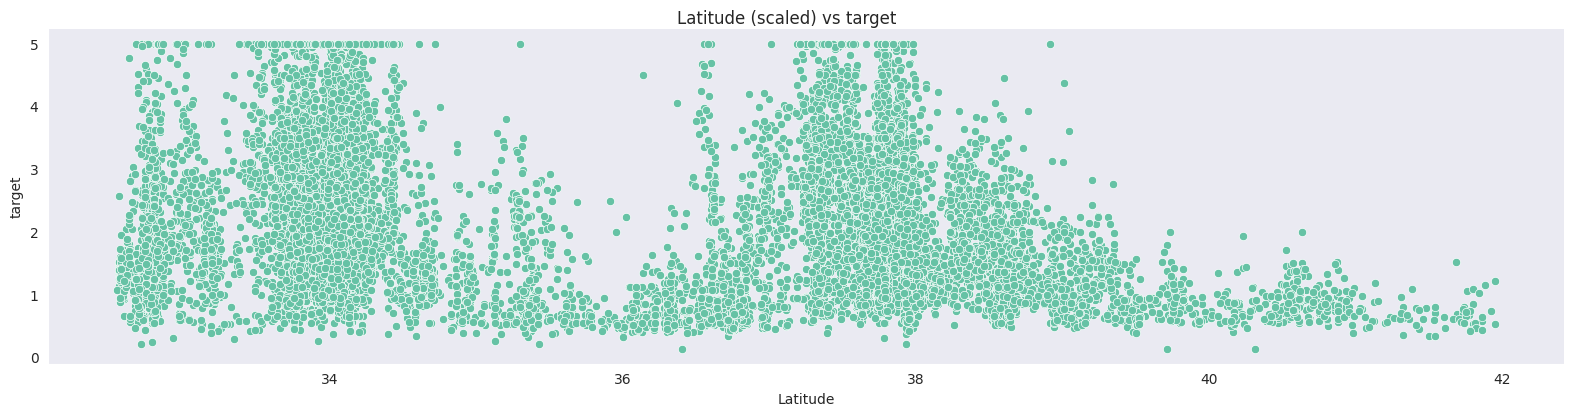

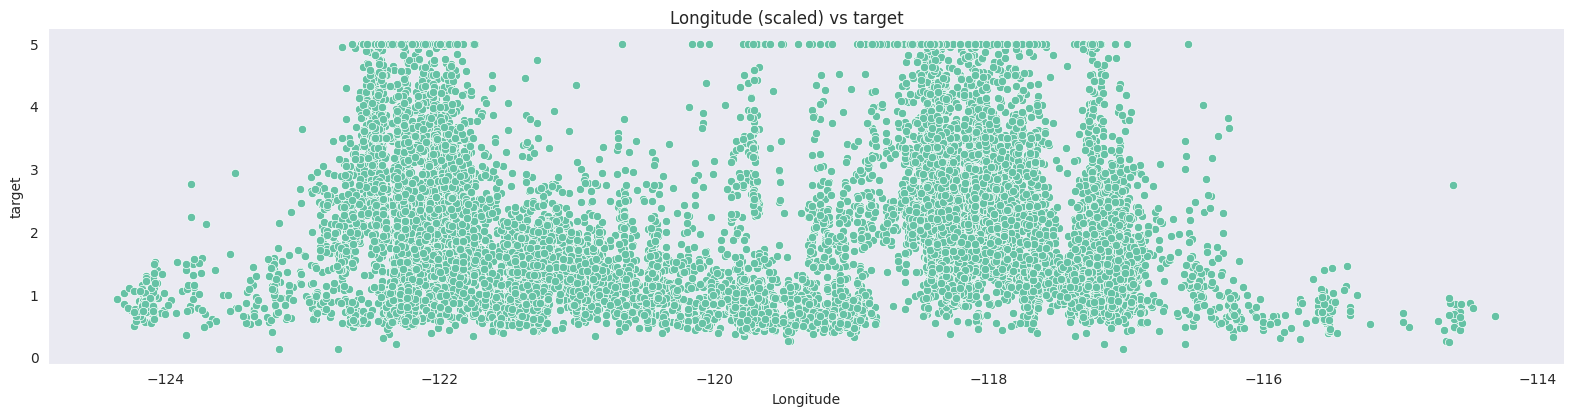

In [107]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Plot de cada variable con las ventas
#iterado porque no caben en un solo render


caled_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
scaled_train_df['target'] = y_train.values



# Graficar cada variable escalada contra target
for col in X_train.columns:
    sns.pairplot(scaled_train_df, x_vars=col, y_vars='target', height=4, aspect=4, kind='scatter')
    plt.suptitle(f"{col} (scaled) vs target", y=1.02)
    plt.show()



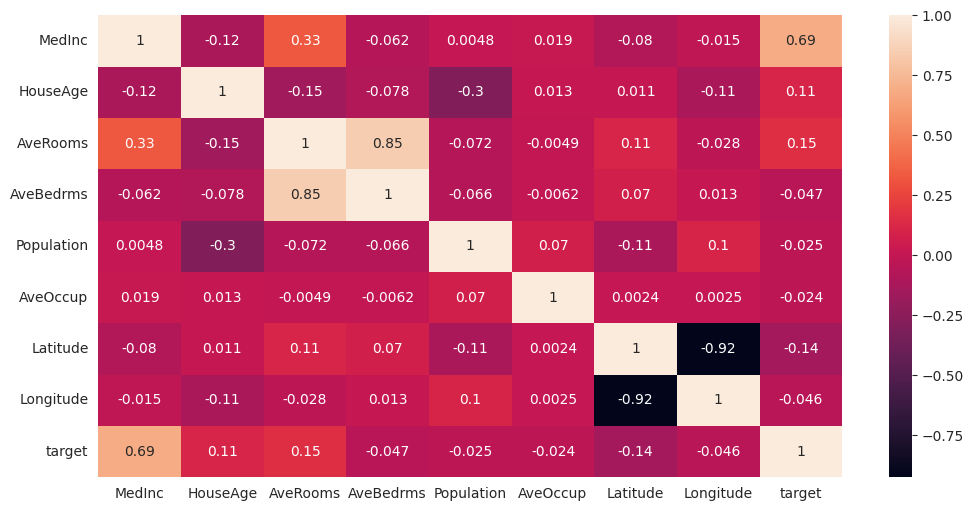

In [108]:
# heatmap para ver relacion entre variables
sns.heatmap(housing_df.corr(), cmap="rocket", annot = True)
plt.show()

In [109]:
#  4. ENTRENAMIENTO 

# mejor valor de alpha
# se usa validacion cruzada
alphas = np.logspace(-6, 6, 100)  
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error') # usa error**2 medio como metrica
ridge_cv.fit(X_train_scaled, y_train)

print(f"\nMejor valor alfa: {ridge_cv.alpha_}")

modelo_ridge = Ridge(alpha=ridge_cv.alpha_)
modelo_ridge.fit(X_train_scaled, y_train)




Mejor valor alfa: 0.093260334688322


,alpha,np.float64(0.093260334688322)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [110]:
# 5. EVALUACIÓN 

# Predicciones
y_train_pred = modelo_ridge.predict(X_train_scaled)
y_test_pred = modelo_ridge.predict(X_test_scaled)

# Métricas de entrenamiento
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Métricas de prueba
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nMÉTRICAS DE ENTRENAMIENTO:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: ${train_rmse * 100000:.2f}")
print(f"  MAE: ${train_mae * 100000:.2f}")

print("\nMÉTRICAS DE PRUEBA:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: ${test_rmse * 100000:.2f}")
print(f"  MAE: ${test_mae * 100000:.2f}")


MÉTRICAS DE ENTRENAMIENTO:
  R² Score: 0.6126
  RMSE: $71967.57
  MAE: $52862.80

MÉTRICAS DE PRUEBA:
  R² Score: 0.5758
  RMSE: $74557.91
  MAE: $53319.95


In [111]:
# 6. COEFICIENTES
coeficientes = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': modelo_ridge.coef_
})
coeficientes = coeficientes.sort_values('Coeficiente', key=abs, ascending=False)
print(coeficientes.to_string(index=False))

Característica  Coeficiente
      Latitude    -0.896858
     Longitude    -0.869770
        MedInc     0.854378
     AveBedrms     0.339236
      AveRooms    -0.294392
      HouseAge     0.122553
      AveOccup    -0.040829
    Population    -0.002305


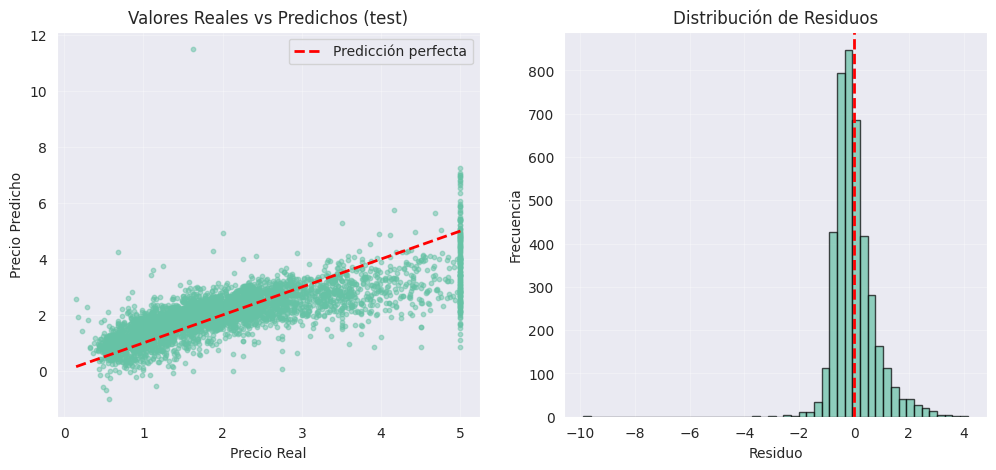

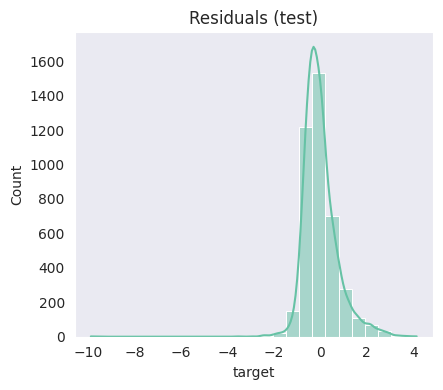

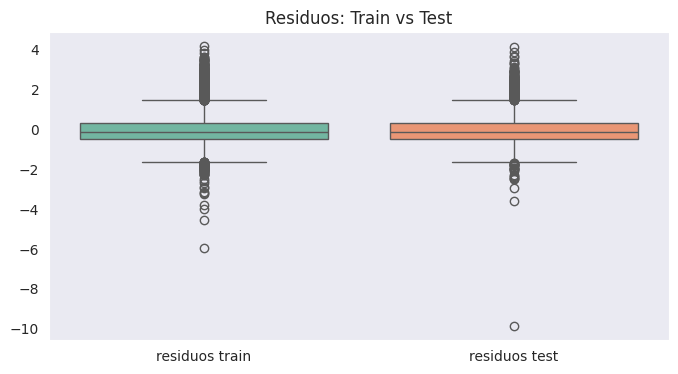

In [112]:

sns.set_style("dark")
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)

# Gráfico 1: Valores reales vs predichos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Valores Reales vs Predichos (test)')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Distribución de residuos

esiduos_test = np.asarray(y_test.reset_index(drop=True)).ravel() - np.asarray(y_test_pred).ravel()
residuos_train = np.asarray(y_train.reset_index(drop=True)).ravel() - np.asarray(y_train_pred).ravel()

plt.subplot(1, 2, 2)
plt.hist(residuos, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)


plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(residuos, kde=True, bins=25)
plt.title("Residuals (test)")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
sns.boxplot(data=[residuos_train, residuos])
plt.xticks([0,1], ["residuos train", "residuos test"])
plt.title("Residuos: Train vs Test")
plt.show()

In [113]:
# la hora de la verdad
# testeamos

# Tomar una muestra del conjunto de prueba
ejemplo = X_test.iloc[0:1]
ejemplo_scaled = scaler.transform(ejemplo)
prediccion = modelo_ridge.predict(ejemplo_scaled)[0]
real = y_test.iloc[0]

print("\nCaracterísticas de la vivienda:")
for col in ejemplo.columns:
    print(f"  {col}: {ejemplo[col].values[0]:.2f}")

print(f"\nPrecio Real: ${real * 100000:.2f}")
print(f"Precio Predicho: ${prediccion * 100000:.2f}")
print(f"Error: ${abs(real - prediccion) * 100000:.2f}")



Características de la vivienda:
  MedInc: 1.68
  HouseAge: 25.00
  AveRooms: 4.19
  AveBedrms: 1.02
  Population: 1392.00
  AveOccup: 3.88
  Latitude: 36.06
  Longitude: -119.01

Precio Real: $47700.00
Precio Predicho: $71915.54
Error: $24215.54
